In [55]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt


In [56]:
# load IMDb dataset from Hugginface
dataset = load_dataset('imdb')
train_texts, train_labels = dataset['train']['text'], dataset['train']['label']
test_text, test_labels = dataset['test']['text'], dataset['test']['label']

In [57]:
# tokenize and vocabulary
tokenizer = get_tokenizer('basic_english')

def yield_tokens(texts):
    for text in texts:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_texts), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [58]:
# text to tensor
def text_pipeline(x):
    return vocab(tokenizer(x))

# custom dataset

class IMDbDataset(Dataset):
    
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels


    def __getitem__(self, idx):
        x = torch.tensor(text_pipeline(self.texts[idx]), dtype=torch.int64)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x,y
    

    def __len__(self):
        return len(self.labels)


In [59]:
# collate function with padding

from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
    text_list, label_list = [], []
    for _text, _label in batch:
        text_list.append(_text)
        label_list.append(_label)

    return pad_sequence(text_list, batch_first=True), torch.tensor(label_list)


In [60]:
# Dataloaders

train_data = IMDbDataset(train_texts[:5000], train_labels[:5000])
test_data = IMDbDataset(test_text[:1000], test_labels[:1000])


train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=collate_batch)


In [61]:
# simple model

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)


In [62]:
# initialize

model = SentimentClassifier(len(vocab), embed_dim=64, num_class=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [63]:
# training loop

train_loss_vals, train_acc_vals = [], []

for epoch in range(5):
    total_loss, total_correct, total = 0, 0, 0 
    model.train()
    for text, labels in train_loader:
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total += labels.size(0)
        total_correct += (output.argmax(1) == labels).sum().item()

    train_loss_vals.append(total_loss / len(train_loader))
    train_acc_vals.append(total_correct / total)
    print(f'epoch {epoch+1}: Loss={train_loss_vals[-1]:.4f}, Acc={train_acc_vals[-1]:.4f}')

epoch 1: Loss=0.0890, Acc=0.9760
epoch 2: Loss=0.0391, Acc=0.9998
epoch 3: Loss=0.0314, Acc=1.0000
epoch 4: Loss=0.0258, Acc=1.0000
epoch 5: Loss=0.0229, Acc=1.0000


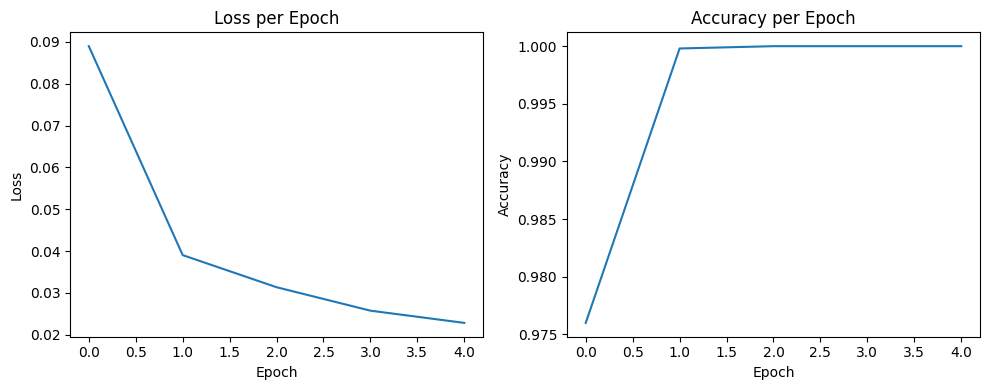

In [64]:

# Plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_vals, label='Train Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_vals, label='Train Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [65]:
# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for text, labels in test_loader:
        output = model(text)
        preds = output.argmax(1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 1.0000


In [ ]:
# test